In [129]:
"""
Disclaimer: this script has been co-developed with ChatGPT

We want to build a (n_models x 1032) array of Northern Hemisphere sea-ice extent (siextentn),
with columns = months from 2015-01 to 2100-12. The data is pre-processed thanks to Annelies Sticker.

Requirements:
  pip install xarray netCDF4 cftime numpy pandas

Notes:
- Handles non-standard calendars via xarray's cftime support.
- If a model is missing months (e.g., after 2099-12), the corresponding entries are NaN.
- Saves:
    - siextentn_s585_2015-2100.npy (float64 array)
    - siextentn_models.txt (model names, one per line, row-aligned with the array)
    - siextentn_time_months.csv (ISO YYYY-MM for each column)
"""

import re
import glob
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path
from scipy    import stats
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = "Arial Narrow"

In [207]:
#dataDir = "Jakob_data/MME_selected/"
#pattern = dataDir + "/" + "*" + "/" + "siextentn_SImon_*_r*i*p*f*_gn_" + "??????-??????.nc"

#dataDir = "allsiextentn/"
#pattern = dataDir + "/"  + "siextentn_SImon_*_r*i*p*f*_gn_" + "??????-??????.nc"

dataDir = "dataFinalFigure/"
pattern = dataDir + "/"  + "siextentn_SImon_*_r*i*p*f*_gn_" + "??????-??????.nc"

#print(pattern)
files = sorted(glob.glob( pattern))
nFiles = len(files)

varName = "siextentn"
print("Nb files: " + str(len(files)))

A = np.full((nFiles, 3000), np.nan)

for i, f in enumerate(files):

    #print(f)
    ds = xr.open_dataset(f, decode_times=True, use_cftime=True)
    data = ds[varName].values
    if np.max(data) > 1e20:
        data = data / 1e25 # FGOALS 
         #.sel(time=da["time"].dt.month == 9)
    #try:
    #    sep = da.sel(time_bnds=da["time_bnds"].dt.month == 9).values
    #except KeyError:
    #    print('zetzet')
    #    try:
    #        sep =   da.sel(time=da["time"].dt.month == 9).values
    #    except TypeError:
    #        "stop"
    #print(data.shape)
    A[i, 0:len(data)] = data.squeeze()
   


Nb files: 388


/opt/anaconda3/lib/python3.12/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'siextentn' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/opt/anaconda3/lib/python3.12/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'siextentn' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/opt/anaconda3/lib/python3.12/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'siextentn' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/opt/anaconda3/lib/python3.12/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'siextentn' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/opt/anaconda3/lib/python3.12/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'siextentn' has multip

/var/folders/m3/rlnbxzw916zg5rxbzlfc01h40000gq/T/ipykernel_37456/2578683125.py:26: RuntimeWarning: Mean of empty slice
  series_smoothed_5yr[m] = np.nanmean(series[m-2:m+2])


[5.118363857269287, 2.801226743808, 4.162281013248, 3.7009966373443604, 4.530060291290283, 4.9402384757995605, 2.573714849792, 2.126495744, 2.1317481994628906, 2.0337138175964355, 3.2784788608551025, 2.252638578414917, 2.0523855686187744, 1.9074276685714722, 3.2004103660583496, 2.0860939025878906, 2.046405076980591, 3.0841586589813232, 2.769141435623169, 2.8561999797821045, 3.8752527236938477, 2.8194637298583984, 2.8665223121643066, 3.2261152267456055, 2.090733766555786, 3.761345624923706, 1.4846476316452026, 2.7953882217407227, 2.31160831451416, 4.813567638397217, 2.0795366764068604, 3.4709300994873047, 3.65105774592, 1.943210819584, 4.8767571449279785, 2.345126152038574, 4.522677633024, 3.643784822784, 3.8030927181243896, 3.423844814300537, 4.06386376704, 3.628878528512, 3.573925733566284, 2.626720104448, 2.930319556608, 1.9065234661102295, 4.648499488830566, 4.378632545471191, 2.8348045349121094, 4.526623725891113, 3.013643503189087, 3.213533118464, 3.350051684352, 2.662998212608, 1

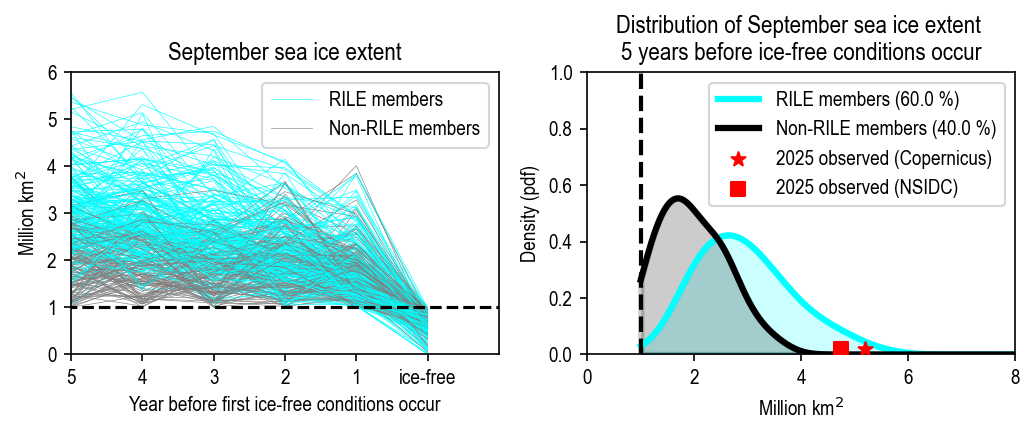

In [211]:

# Aligning everyhing on the first ice free date
fig, ax = plt.subplots(1, 2, figsize = (7, 3), dpi = 150)
nBack = 20 # number of years back in time counting backwards from first ice -free date

B = np.full((A.shape[0], nBack), np.nan) # B is a nfile by  matrix that stores the nBack values before ice free conditions occur
C = np.full((A.shape[0], nBack), np.nan) # C is a nmod by 10 matrix that stores the nBack values of *trends* until ice free conditions occur

# To construct the PDFs
valueRILE = list()
valueNoRILE = list()

firstTimeRILE = True
firstTimeNoRILE=True # For labels

for i in range(A.shape[0]):
    
    # Find the first instance of ice-free
    series = A[i, 8::12]
    series_smoothed_5yr = np.full(len(series), np.nan)
    series_smoothed_5yr[:] = series[:]
    series_smoothed_5yr[0] = np.nan
    series_smoothed_5yr[1] = np.nan
    series_smoothed_5yr[-1] = np.nan
    series_smoothed_5yr[-2] = np.nan
    for m in range(2, len(series) - 2):
        series_smoothed_5yr[m] = np.nanmean(series[m-2:m+2])

    
    loc = np.where(series < 1.0)
    if len(loc[0]) >= 1: # if ice free conditions occur
        first = loc[0][0]
        newseries=series[:first + 1] # Note that newseries is ordered with increasing time. Its last element is a <1.0 event.
        newseries_smoothed_5yr=series_smoothed_5yr[:first + 1] # The same data but for the smoothed time series.


  
        try:
            B[i, :]= newseries[-nBack:]
        except ValueError:
            # This happens if newseries is shorter than nBack; in that case we put the entire newseries
            B[i, -len(newseries):] = newseries

        newtimeaxis = np.arange(100, 100-len(newseries), -1)[-1::-1]
      
        
        # RILES are identified based on a period lasting at least 4 years, with the trend in the 5-year running mean minimum SIE consistently lower than or equal to 􀀀0:3 106 km2 yr1. (Auclair & Tremblay 2018, Sticker et al 2025"
        #print("Series:")
        #print(series)
        #print("Series, smoothed")
        #print(series_smoothed_5yr)
        
        # We check if the trend of the smoothed time series ending in the ice-free conditions satisfy the rile criterion
        foundRILE = False
        for lag in [4, 5, 6, 7, 8, 9]:
            p = np.polyfit(range(len(newseries_smoothed_5yr[-lag:])), newseries_smoothed_5yr[-lag:], 1)
            #print(newseries_smoothed_5yr[-lag:])
            #print(p[0])
            if p[0] < -0.3:
                foundRILE = True
           

        if foundRILE:
            valueRILE.append(newseries[-5]) # Appending the value of sea ice extent five years before ice-free
        else:
            valueNoRILE.append(newseries[-5])
        

        #print(foundRILE)

        if foundRILE:
            color = "cyan"
            if firstTimeRILE:
                firstTimeRILE = False
                label = "RILE members"
            else:
                label = None

        else:
            color = "grey"
            if firstTimeNoRILE:
                firstTimeNoRILE = False
                label = "Non-RILE members"
            else:
                label = None

        ax[0].plot(newtimeaxis,newseries, color = color, lw = 0.3, label = label)

ax[0].set_xlabel("Year before first ice-free conditions occur")
ax[0].set_ylabel("Million km$^2$")
ax[0].set_title("September sea ice extent")

ax[0].set_xticks([100, 99, 98, 97, 96, 95, 94, 93, 92, 91, 90], ["ice-free", 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])                   
ax[0].plot((0, 200), (1, 1), "k--")
ax[0].set_xlim(95, 101)
ax[0].set_ylim(0, 6)
ax[0].legend()
plt.tight_layout()


propRILE = np.round(len(valueRILE) / ((len(valueRILE) + len(valueNoRILE))) * 100, 0)
propNoRILE = np.round(len(valueNoRILE) / ((len(valueRILE) + len(valueNoRILE))) * 100, 0)

ax[1].set_title("Distribution of September sea ice extent \n5 years before ice-free conditions occur")

xpdf = np.linspace(1.0, 10.0, 1000)


kernel = stats.gaussian_kde(np.array(valueRILE), bw_method = 0.5)
pdf = kernel(xpdf).T
ax[1].fill_between(xpdf, pdf , lw = 3, alpha = 0.2, color = "cyan", )
ax[1].plot(xpdf, pdf , lw = 3,              color = "cyan", label = "RILE members (" + str(propRILE) + " %)")

kernel = stats.gaussian_kde(np.array(valueNoRILE), bw_method = 0.5)
pdf = kernel(xpdf).T
ax[1].plot(xpdf, pdf , lw = 3,                      color = "black", label = "Non-RILE members (" + str(propNoRILE) + " %)")
ax[1].fill_between(xpdf, pdf , lw = 3, alpha = 0.2, color = "black", )





ax[1].plot((1.0, 1.0), (0.0, 100), "k--", lw = 2)
ax[1].set_xlabel("Million km$^2$")
ax[1].set_ylabel("Density (pdf)")


   
ax[1].set_xlim(0.0, 8.0)
ax[1].set_ylim(0.0, 1.0)

ax[1].scatter(5.2, 0.02, 50, marker = "*", zorder = 10000, color = "red", label = "2025 observed (Copernicus)")
ax[1].scatter(4.75, 0.02, 50, marker = "s", zorder = 10000, color = "red", label = "2025 observed (NSIDC)")

ax[1].legend() 

plt.tight_layout()

print(valueRILE)